In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['font.size'] = 14

cities_label = {"London":"london", 
                "New York":"newyork", 
                "Beijing":"beijing",
                "Hong Kong":"hongkong",
                "Singapore":"singapore"}

colors = ["#3964DF", "#E0C645","#E02927",  "#65D8DF", "#AE02DE"]

In [2]:
def reward(P_ac, P_heat, tbuild):
    w=0.1
    P_ac = P_ac/3.6/0.43
    P_heat = P_heat/0.9/0.96
    r = -w*1*(P_ac + P_heat) - (1-w)*1*(abs(tbuild - 24 - 273.15) + abs(tbuild - 18 - 273.15))
    return r

In [3]:
def plot_reward(ax, ds, ds_rl, label, 
                timeslice=("2012", "2013"), color='blue'):
    ds['reward'] = reward(ds['URBAN_AC'].isel(landunit=1), ds['URBAN_HEAT'].isel(landunit=1), ds['TBUILD'].isel(landunit=1))
    ds_rl['reward'] = reward(ds_rl['URBAN_AC'].isel(landunit=1), ds_rl['URBAN_HEAT'].isel(landunit=1), ds_rl['TBUILD'].isel(landunit=1))
    
    ds_diff = ds_rl['reward'] - ds['reward']
    
    #ds = ds['reward'].sel(time=slice(*timeslice)).resample(time='1ME').mean()
    #ds_rl = ds_rl['reward'].sel(time=slice(*timeslice)).resample(time='1ME').mean()
    
    ds_diff_mean = ds_diff.sel(time=slice(*timeslice)).resample(time='1ME').mean()
    print(label, ": " , ds_diff.mean().values.round(2))
    ds_diff_std = ds_diff.sel(time=slice(*timeslice)).resample(time='1ME').std()
    
    ds_diff_mean.plot(ax=ax, label=label, color=color)
    ax.fill_between(ds_diff_mean.time.values, ds_diff_mean.values-ds_diff_std.values, ds_diff_mean.values+ds_diff_std.values, 
                    alpha=0.3, color=color)
    
    ax.set_ylabel('Reward')
    
    return ds_diff

def plot_var(ax, ds, ds_rl, label, var, timeslice=("2012", "2013"), color='blue', ylabel='Building temperature [K]'):
    if var in ['TSA', 'RH2M', 'WASTEHEAT']:
        pft = 4 if var == 'WASTEHEAT' else 1
        ds=ds[var].sel(time=slice(*timeslice)).isel(pft=pft)
        ds_rl=ds_rl[var].sel(time=slice(*timeslice)).isel(pft=pft)
        ds_diff = ds_rl - ds
        ds_diff_mean = ds_diff.sel(time=slice(*timeslice)).resample(time='1ME').mean()
        ds_diff_std = ds_diff.sel(time=slice(*timeslice)).resample(time='1ME').std()
        ds_diff_mean.plot(ax=ax, label=label, color=color)
        ax.fill_between(ds_diff_mean.time.values, ds_diff_mean.values-ds_diff_std.values, ds_diff_mean.values+ds_diff_std.values, 
                        alpha=0.3, color=color)
        print(label, ": " , ds_diff.mean().values.round(2))
        ax.set_ylabel(ylabel)
    else:
        ds=ds[var].sel(time=slice(*timeslice)).isel(landunit=1)
        ds_rl=ds_rl[var].sel(time=slice(*timeslice)).isel(landunit=1)
        ds_diff = ds_rl - ds
        ds_diff_mean = ds_diff.sel(time=slice(*timeslice)).resample(time='1ME').mean()
        ds_diff_std = ds_diff.sel(time=slice(*timeslice)).resample(time='1ME').std()
        ds_diff_mean.plot(ax=ax, label=label, color=color)
        ax.fill_between(ds_diff_mean.time.values, ds_diff_mean.values-ds_diff_std.values, ds_diff_mean.values+ds_diff_std.values, 
                        alpha=0.3, color=color)
        print(label, ": " , ds_diff.mean().values.round(2))
        ax.set_ylabel(ylabel)
    
    return ds_diff
        

def plot_TG(ax, ds, ds_rl, label, var, timeslice=("2012", "2013"), color='blue'):
    
    ds = ds.assign_coords(column=ds.cols1d_itype_col.values)
    ds_rl = ds_rl.assign_coords(column=ds_rl.cols1d_itype_col.values)   
    
    cols_name = {"Roof" : 71,
                 "Sunlit wall" : 72,
                 "Shaded wall" : 73,
                 "Impervious road" : 74,
                 "Pervious road" : 75}
    
    colors = ["#3964DF", "#E0C645","#E02927",  "#65D8DF", "#AE02DE"]
    
    for col in cols_name:
        ds_plot = ds[var].sel(time=slice(*timeslice), column=cols_name[col])
        ds_rl_plot = ds_rl[var].sel(time=slice(*timeslice), column=cols_name[col])
        ds_diff = ds_rl_plot - ds_plot
        ds_diff_mean = ds_diff.sel(time=slice(*timeslice)).resample(time='1ME').mean()
        ds_diff_std = ds_diff.sel(time=slice(*timeslice)).resample(time='1ME').std()
        ds_diff_mean.plot(ax=ax, label=col,
                          color=colors[cols_name[col]-71])
        #ax.fill_between(ds_diff_mean.time.values, ds_diff_mean.values-ds_diff_std.values, ds_diff_mean.values+ds_diff_std.values, 
        #                alpha=0.3, color=colors[col-71])
        print(col, ": " , ds_diff.mean().values.round(2))
    
    ax.set_title('')
    ax.set_ylabel('Surface temperature [K]')
    
    return ds_diff

In [4]:
def get_text_position(var):
    
    if var == "TSA":
        pos_dict = {
            "London": (0.20, 0.9),
            "New York": (0.55, 0.9),
            "Beijing": (0.55, 0.9),
            "Hong Kong": (0.85, 0.9),
            "Singapore": (0.20, 0.1)
        }
        
    elif var == "TBUILD":
        pos_dict = {
            "London": (0.85, 0.1),
            "New York": (0.85, 0.1),
            "Beijing": (0.85, 0.1),
            "Hong Kong": (0.85, 0.9),
            "Singapore": (0.85, 0.9)
        }
        
    elif var == "RH2M":
        pos_dict = {
            "London": (0.20, 0.1),
            "New York": (0.20, 0.1),
            "Beijing": (0.20, 0.1),
            "Hong Kong": (0.85, 0.1),
            "Singapore": (0.20, 0.9)
        }
        
    elif var == "WASTEHEAT":
        pos_dict = {
            "London": (0.85, 0.9),
            "New York": (0.85, 0.9),
            "Beijing": (0.85, 0.9),
            "Hong Kong": (0.85, 0.9),
            "Singapore": (0.85, 0.1)
        }
        
    return pos_dict

def plotting(var="reward", ylabel='Building temperature [K]'):
    figs = plt.figure(figsize=(10, 7))
    
    mean_reward_diff = np.zeros(5)
    std_reward_diff = np.zeros(5)
    i = 0
    if var in ['TG', 'TSKIN', 'TSA', 'RH2M', 'WASTEHEAT', "TBUILD"]:
        j = 0
    else:
        j = 1 
    
    for city in cities_label:
        ax = figs.add_subplot(3, 2, j+1)
        if city == "London":
            timeslice = ("2012", "2012")
        else:
            timeslice = ("2021", "2021")
        
        print(city)
        ds = xr.open_dataset('../hac_on_wasteheat/'+cities_label[city] + "/default.nc")
        ds_rl = xr.open_dataset('../clmu_sac_output/'+cities_label[city] + "_sac_clmu_sac.nc")
        if var == "reward":
            ds_diff = plot_reward(ax, ds, ds_rl, ylabel, timeslice, colors[i])
            ax.set_ylabel(ylabel)
            diffmean = ds_diff.mean().values.round(2)
            
            if city in ["Beijing", "Singapore", "London"]:
                ax.text(0.85, 0.1, f"Mean: {diffmean:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

            else:
                ax.text(0.85, 0.9, f"Mean: {diffmean:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            
        elif var in ['TG', 'TSKIN']:
            ds_diff=plot_TG(ax, ds, ds_rl, "RL - Default", "TG", timeslice, colors[i])
            ax.set_ylabel(ylabel)
            
        else:
            ds_diff = plot_var(ax, ds, ds_rl, "RL - Default", var, timeslice, colors[i], ylabel)
            
            
            diffmean = ds_diff.mean().values.round(2)
            if var in ['TSA', 'TBUILD', 'TG', 'TSKIN']:
                unit = "K"
            elif var == "RH2M":
                unit = "%"
            elif var == "WASTEHEAT":
                unit = "W/m2"
                
            pos_dict = get_text_position(var)
            ax.text(pos_dict[city][0], pos_dict[city][1], 
                    f"Mean: {diffmean:.2f} {unit}", horizontalalignment='center', 
                    verticalalignment='center', transform=ax.transAxes)
        
        ax.set_title(city, loc='left', fontsize=14)
        
        if i in [3,4]:
            ax.set_xlabel("Month")
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])
            

        mean_reward_diff[i] = ds_diff.mean().values
        std_reward_diff[i] = ds_diff.std().values
            
        i += 1
        j += 1
    
    if var in ['TG', 'TSKIN']:
        handles, labels = ax.get_legend_handles_labels()[0:5]
        figs.legend(handles, labels, loc='lower left',
                        fontsize=14, ncol=1, bbox_to_anchor=(0.55, 0.1),
                        frameon=False)
    
    elif var == "reward":
        ax = figs.add_subplot(3, 2, 1)
        ax.hlines(y=list(cities_label.keys())[::-1], 
                  xmin=0, xmax=mean_reward_diff[::-1], 
                  color='gray', lw=1.5, alpha=0.5, zorder=0)
        
        print(mean_reward_diff[::-1], list(cities_label.keys())[::-1])
        
        ax.scatter(mean_reward_diff[::-1], 
                   list(cities_label.keys())[::-1], 
                   color=colors[::-1], 
                   s=std_reward_diff[::-1]*50, 
                   linewidths=1, edgecolors='black', zorder=1)
        if np.any(mean_reward_diff < 0):
            ax.axvline(x=0, color='gray', lw=1.5, alpha=0.5)
        else:
            ax.set_xlim(0)
        ax.set_xlabel(f'mean {ylabel}')
    
    figs.tight_layout()
    figs.savefig("./figs/"+var+".pdf", dpi=300, bbox_inches='tight')
    figs.show()
    

London
R$_{\mathrm{diff}}$ :  0.92
New York
R$_{\mathrm{diff}}$ :  1.35
Beijing
R$_{\mathrm{diff}}$ :  6.16
Hong Kong
R$_{\mathrm{diff}}$ :  2.41
Singapore
R$_{\mathrm{diff}}$ :  6.78
[6.78375435 2.40527272 6.15741396 1.35459948 0.91523719] ['Singapore', 'Hong Kong', 'Beijing', 'New York', 'London']


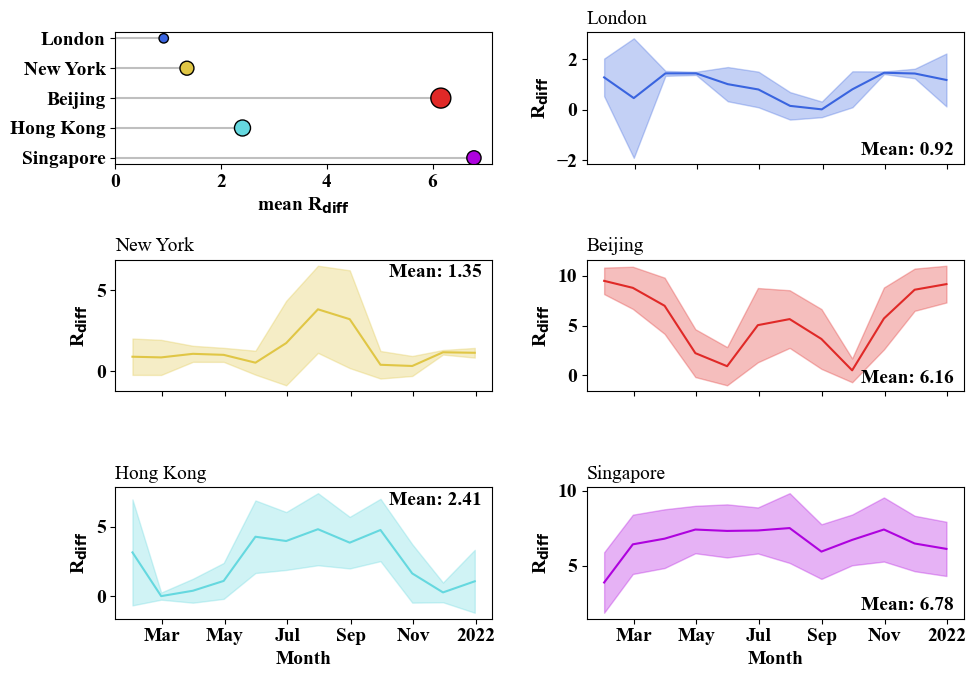

In [5]:
plotting("reward", ylabel='R$_{\\mathrm{diff}}$')

London
RL - Default :  2.37
New York
RL - Default :  1.14
Beijing
RL - Default :  2.62
Hong Kong
RL - Default :  -0.77
Singapore
RL - Default :  -3.82


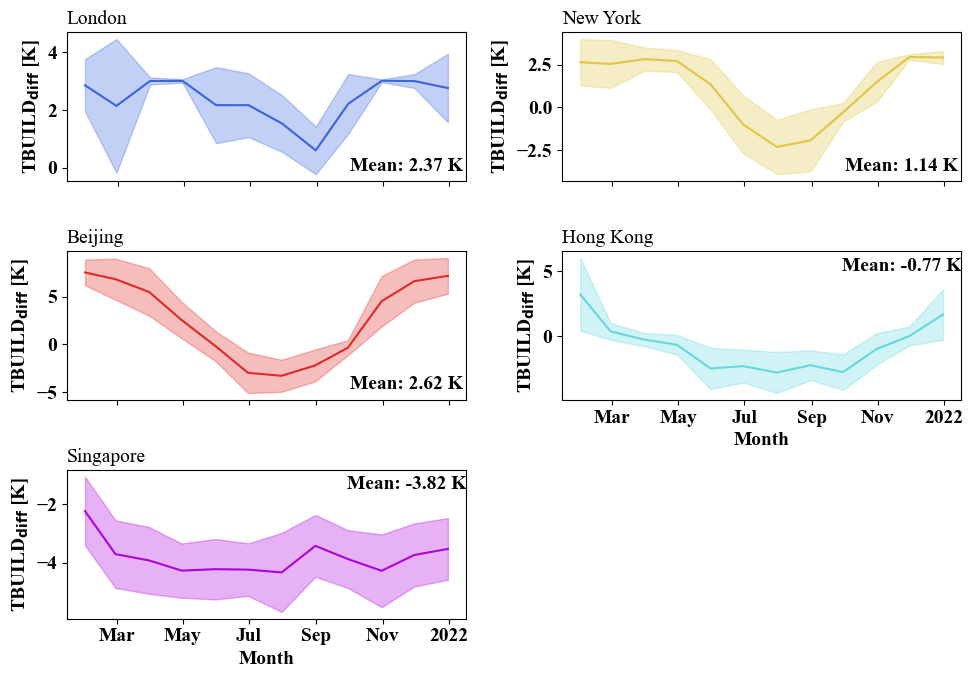

In [6]:
plotting("TBUILD", ylabel='TBUILD$_{\\mathrm{diff}}$ [K]')

London
RL - Default :  0.08
New York
RL - Default :  0.03
Beijing
RL - Default :  0.09
Hong Kong
RL - Default :  0.0
Singapore
RL - Default :  -0.06


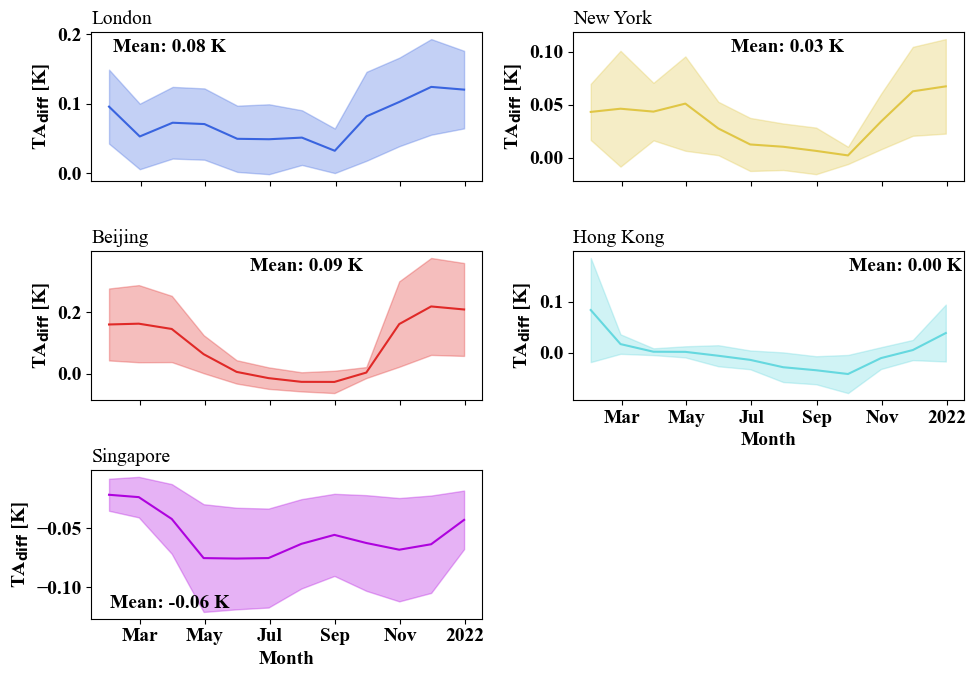

In [7]:
plotting("TSA", 'TA$_{\\mathrm{diff}}$ [K]')

London
RL - Default :  -0.45
New York
RL - Default :  -0.18
Beijing
RL - Default :  -0.42
Hong Kong
RL - Default :  0.03
Singapore
RL - Default :  0.48


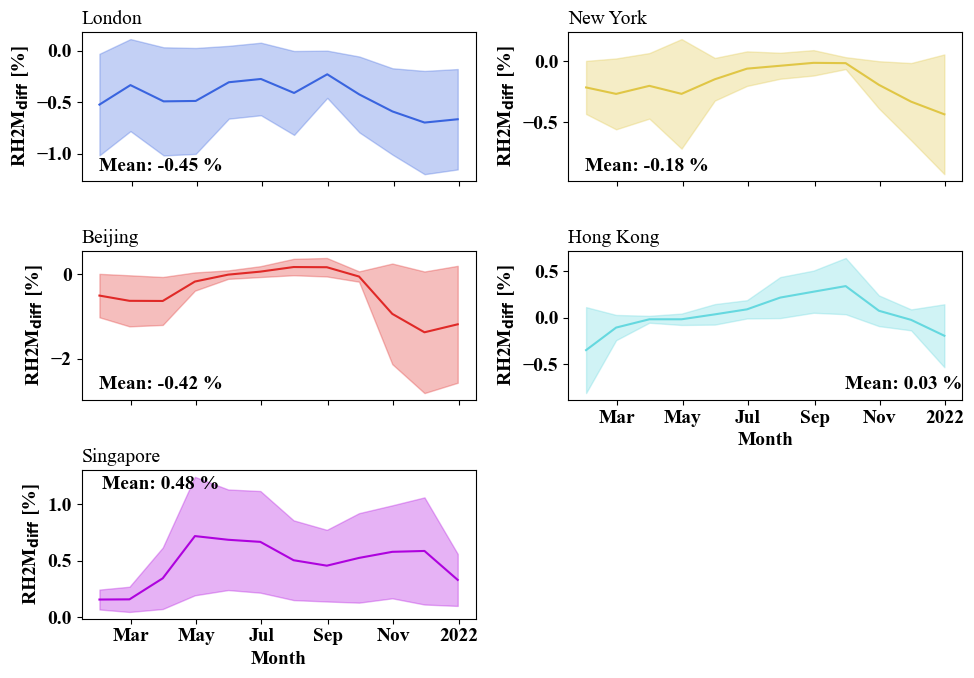

In [8]:
plotting("RH2M", "RH2M$_{\\mathrm{diff}}$ [%]")

London
RL - Default :  0.93
New York
RL - Default :  2.17
Beijing
RL - Default :  1.95
Hong Kong
RL - Default :  1.28
Singapore
RL - Default :  3.76


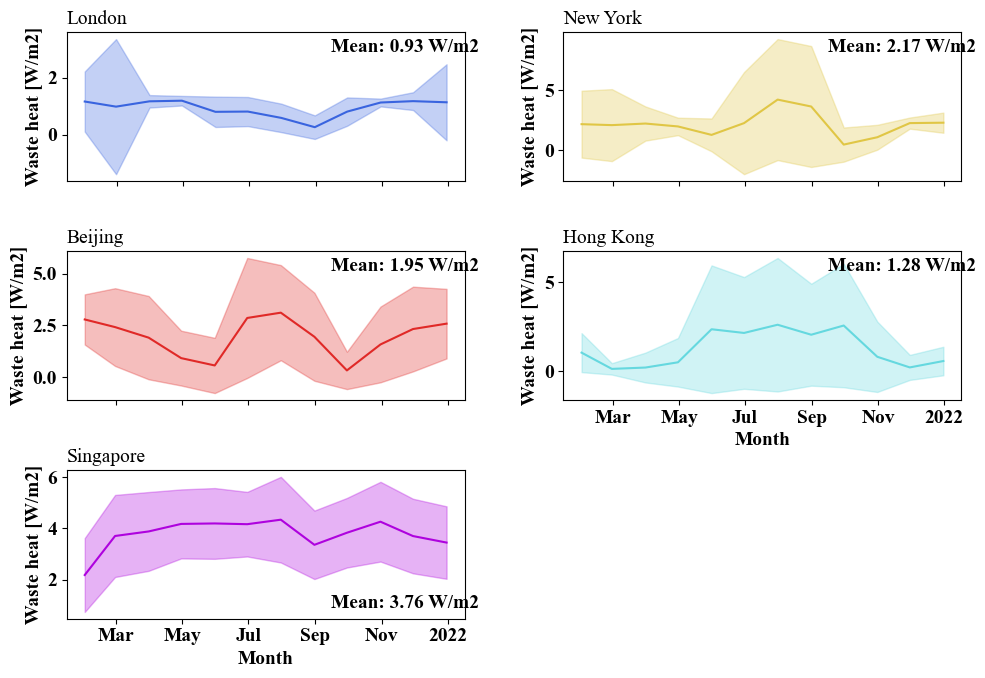

In [9]:
plotting("WASTEHEAT", "Waste heat [W/m2]")

London
Roof :  0.07
Sunlit wall :  0.22
Shaded wall :  0.22
Impervious road :  0.12
Pervious road :  0.12
New York
Roof :  0.04
Sunlit wall :  0.14
Shaded wall :  0.14
Impervious road :  0.19
Pervious road :  0.18
Beijing
Roof :  0.1
Sunlit wall :  0.42
Shaded wall :  0.43
Impervious road :  0.24
Pervious road :  0.21
Hong Kong
Roof :  0.01
Sunlit wall :  -0.09
Shaded wall :  -0.09
Impervious road :  0.1
Pervious road :  0.11
Singapore
Roof :  -0.03
Sunlit wall :  -0.39
Shaded wall :  -0.39
Impervious road :  0.25
Pervious road :  0.14


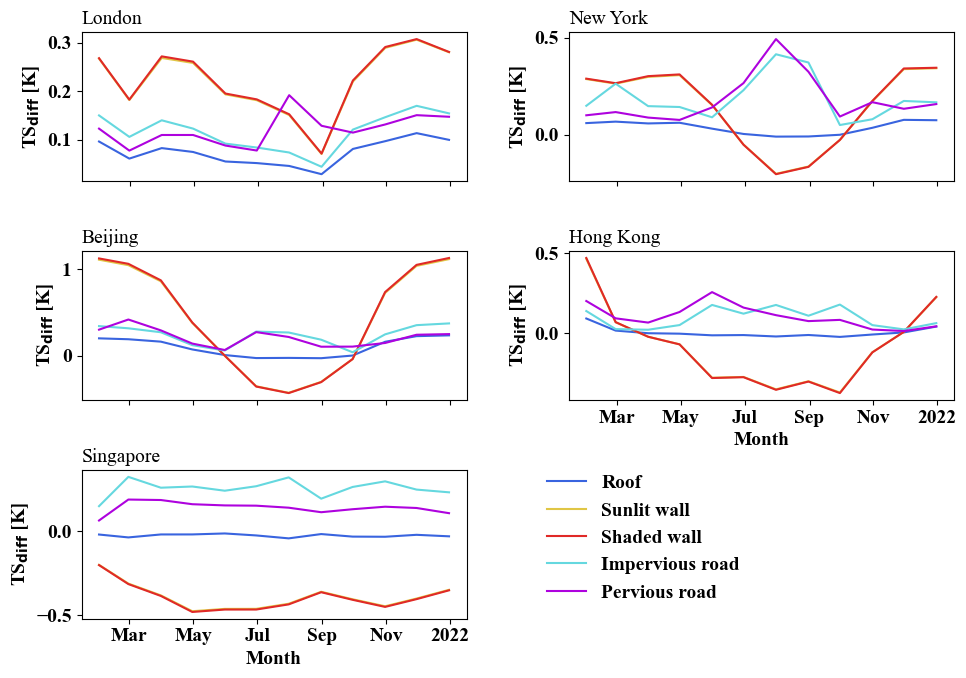

In [10]:
plotting("TSKIN", "TS$_{\\mathrm{diff}}$ [K]")